### Code Dependencies

##### a) General libraries and functions

In [1]:
%%capture
import cv2
import scipy.io
import numpy as np
from PIL import Image
import deeptrack as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage import img_as_float
from shapely.geometry import Point
from matplotlib.patches import Rectangle
from sklearn.metrics import precision_recall_curve, average_precision_score
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

2023-03-22 07:56:12.202070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 07:56:16.855624: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/juanpb27/UTB/objects_detection_lodestar/env/lib/python3.8/site-packages/cv2/../../lib64:
2023-03-22 07:56:16.855891: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 07:56:25.178278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic lib

##### b) Generating ground truth

In [2]:
def draw_bounding_boxes(path, box_size=100):
    # Función para dibujar un cuadro delimitador en una imagen
    def draw_box(event, x, y, flags, param):
        nonlocal x_init, y_init, drawing, top_left_pt, bottom_right_pt, gt_boxes

        # Si se hace clic con el botón izquierdo, comenzar a dibujar
        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            x_init, y_init = x, y

        # Si el botón izquierdo está levantado, dibujar el cuadro delimitador
        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            x_diff, y_diff = x - x_init, y - y_init
            half_box_size = int(box_size / 2)
            top_left_pt = (x - half_box_size, y - half_box_size)
            bottom_right_pt = (x + half_box_size, y + half_box_size)
            cv2.rectangle(image, top_left_pt, bottom_right_pt, (255,0,0), 3)
            # x1, y1, x2, y2
            gt_boxes.append([top_left_pt[0], top_left_pt[1],
                               bottom_right_pt[0], bottom_right_pt[1]])

    # Cargar imagen para procesar con OpenCV
    image = plt.imread(path)

    # Mostrar la imagen en una ventana
    cv2.namedWindow('Ground truth')
    cv2.setMouseCallback('Ground truth', draw_box)

    drawing = False
    x_init, y_init = 0, 0
    top_left_pt, bottom_right_pt = (0, 0), (0, 0)
    gt_boxes = []

    while True:
        cv2.imshow('Ground truth', image)
        k = cv2.waitKey(1)

        # Si se presiona la tecla 'q', salir
        if k == ord('q'):
            break

    # Dibujar los bounding boxes
    #gt_boxes = np.array(gt_boxes)
    for box in gt_boxes:
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), thickness=4)

    cv2.destroyAllWindows()

    # Mostrar la imagen con los bounding boxes
    plt.imshow(image)
    return image, np.array(gt_boxes)


##### c) Object detection

In [3]:
class Preprocessor():

  def __init__(self,
               scales=[1, 2, 4]
               ):
    self.scales = scales

  
  def crop(self, image, x, y, wide):
    cropped_image = image[y: y + wide, x: x + wide]

    return cropped_image

  def normalizate(self, image):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

    return normalized_image

  def resize(self, image, scale):
    resized_image = cv2.resize(image, (0, 0), fx=1/scale, fy=1/scale)

    return resized_image

  def generate_pipeline(self, image, transformations):
    pipeline = dt.Value(image)
    for transformation in transformations:
      pipeline = pipeline >> transformation

    return pipeline

  def create_train_data(self, image):
    normalized_image = self.normalizate(image)
    training_image = np.expand_dims(normalized_image, axis = -1)

    train_set = (self.generate_pipeline(training_image, transformations))
    train_set.plot()

    return train_set

  def load_images(self, data, plot=True):
    dataset = [self.resize(data, scale) for scale in self.scales]
    input_set = [self.normalizate(image) for image in dataset]

    if plot:
      fig, ax = plt.subplots(1, len(input_set), figsize=(25,5))
      fig.tight_layout()
      fig.suptitle('Scaled 3D images')
      for index in range(len(input_set)):
        ax[index].imshow(input_set[index])
    
    return input_set

# --------------------------------------------------------------------
class Trainer():

  def __init__(self,
               filepath,
               model = dt.models.LodeSTAR(input_shape=(None, None, 1)),
               callbacks = [None]
               ):

    self.model = model
    self.filepath = filepath
    self.callbacks = [
        ModelCheckpoint(filepath=self.filepath,
                        save_weights_only=True,
                        monitor='consistency_loss',
                        mode='min',
                        save_best_only=True
                        ),
        EarlyStopping(monitor="total_loss",
                      patience=15,
                      verbose=1,
                      mode="auto",
                      restore_best_weights=True
                      ),
        LearningRateScheduler(lambda epoch, lr: lr if epoch < 10 else lr * np.exp(-0.1))
    ]
  
  def fit(self, train_set, epochs=40, batch_size=8):
    history = self.model.fit(
        train_set,
        epochs = epochs,
        batch_size = batch_size,
        callbacks = self.callbacks)

    return history

  def plot_performance(self, history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    fig.suptitle('Total loss and consistency loss')

    ax1.plot(history.history['total_loss'])
    ax1.set_title('Total loss')
    ax1.set(xlabel='epoch', ylabel='loss')
    ax1.set_ylim([0, 1.5])

    ax2.plot(history.history['consistency_loss'])
    ax2.set_title('Consitency loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.set_ylim([0, 1.5])

    plt.show()

# --------------------------------------------------------------------
class Detector():

  def __init__(self,
               downsample,
               alpha = 0.1,
               cutoff = 0.998,
               mode = "quantile",
               colors = 'rgb',
               model = dt.models.LodeSTAR(input_shape=(None, None, 1)),
               ):
    self.downsample = downsample
    self.alpha = alpha
    self.cutoff = cutoff
    self.mode = mode
    self.colors = colors
    self.model = model

  def detect(self, image, plot=True):
    test_set = image[np.newaxis, :, :, np.newaxis]
    test_image = test_set[:, ::self.downsample, ::self.downsample, :]

    detections = self.model.predict_and_detect(test_image, alpha=self.alpha, beta=1-self.alpha, cutoff=self.cutoff, mode=self.mode)[0]
    detections[:, 1] = detections[:, 1] * self.downsample
    detections[:, 0] = detections[:, 0] * self.downsample

    return detections

  def detect_all(self, images, plot=False):
    detections = []
    
    if plot:
      fig, ax = plt.subplots(1, len(images), figsize=(25, 5))
      fig.tight_layout()
      fig.suptitle('Detections')
    
    for index in range(len(images)):
      det = self.detect(image=images[index])
      detections.append(det)

      if plot:
        ax[index].imshow(images[index])
        ax[index].scatter(detections[index][:, 1], detections[index][:, 0], color=self.colors[index])
      
    return detections

# --------------------------------------------------------------------
class Postprocessor():

  def __init__(self,
               wide=50,
               scales=[1, 2, 4],
               colors = 'rgb'
               ):
    self.wide = wide
    self.scales = scales
    self.colors = colors
  
  def scale_detections(self, detection, scale):
    scaled_detection = detection * scale

    return scaled_detection.tolist()

  def create_boxes(self, detections):
    list_detections = [Point((x,y)) for (y,x) in detections]
    points = gpd.GeoSeries(list_detections)
    boxes = points.buffer(self.wide, cap_style = 3)
    bounds = np.array([boxes[index].bounds for index in range(len(boxes))])

    return boxes, bounds

  def NMSupression(self, boxes, overlapThresh):
    # Malisiewicz et al. - non_max_suppression_fast
    if len(boxes) == 0:
      return []

    if boxes.dtype.kind == "i":
      boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    while len(idxs) > 0:
      last = len(idxs) - 1
      i = idxs[last]
      pick.append(i)

      xx1 = np.maximum(x1[i], x1[idxs[:last]])
      yy1 = np.maximum(y1[i], y1[idxs[:last]])
      xx2 = np.minimum(x2[i], x2[idxs[:last]])
      yy2 = np.minimum(y2[i], y2[idxs[:last]])

      w = np.maximum(0, xx2 - xx1 + 1)
      h = np.maximum(0, yy2 - yy1 + 1)

      overlap = (w * h) / area[idxs[:last]]

      idxs = np.delete(idxs, np.concatenate(([last],
        np.where(overlap > overlapThresh)[0])))
      
    return boxes[pick].astype("int")

  def apply_nms(self, image, list_bounds, overlapThresh=0.3):
    all_bounds = [bounds.tolist() for bounds in list_bounds]
    final_bounds = []

    for index in range(len(all_bounds)):
      final_bounds += all_bounds[index]

    final_bounds = np.array(final_bounds)
    final_detections = self.NMSupression(final_bounds,
                                         overlapThresh=overlapThresh)
    self.plot_results(image, final_detections)

    return final_detections


  def plot_boxes(self, test_image, detections, plot=True):
    list_boxes, list_bounds, scaled_detections = [], [], []

    if plot:
      fig, ax = plt.subplots(figsize=(15, 15))
      plt.imshow(test_image)

    for index in range(len(detections)):
      scaled_det = self.scale_detections(detections[index], self.scales[index])
      scaled_detections.append(scaled_det)

      boxes, bounds = self.create_boxes(scaled_detections[index])
      list_boxes.append(boxes)
      list_bounds.append(bounds)

      if plot:
        boxes.boundary.plot(ax=ax, color = self.colors[index])

    return list_bounds

  def plot_results(self, image, boxes, color='red', lw=2):
    plt.figure()
    plt.imshow(image)

    wide = self.wide * 2
    for i in range(len(boxes)):
      rect = Rectangle((boxes[i][0], boxes[i][1]),wide,wide,
                       edgecolor=color,
                       facecolor='none',
                       lw=lw)
     
      plt.gca().add_patch(rect)

2023-03-22 07:56:35.661319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def test(test_data, model, downsample=1, alpha=0.1, cutoff=0.99, mode="quantile", plotPrevious=True):
  preprocessor = Preprocessor()
  input_set = preprocessor.load_images(test_data, plot=plotPrevious)
  detector = Detector(downsample, model=model, alpha=alpha, cutoff=cutoff, mode=mode)
  detections = detector.detect_all(input_set, plot=plotPrevious)
  postprocessor = Postprocessor()
  test_image = input_set[0]
  bounds = postprocessor.plot_boxes(test_image, detections, plot=plotPrevious)
  final_detections = postprocessor.apply_nms(test_image, bounds)

  return final_detections

##### d) Computing metrics

In [5]:
def calculate_iou(gt_box, pred_box):
    """
    Calcula el IoU (Intersection over Union) entre dos bounding boxes en formato [xmin, ymin, xmax, ymax].
    """
    # Calcula la intersección entre los bounding boxes
    x1 = np.maximum(gt_box[0], pred_box[0])
    y1 = np.maximum(gt_box[1], pred_box[1])
    x2 = np.minimum(gt_box[2], pred_box[2])
    y2 = np.minimum(gt_box[3], pred_box[3])
    intersection = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
    
    # Calcula la unión entre los bounding boxes
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    union = gt_area + pred_area - intersection
    
    # Calcula el IoU
    iou = intersection / union
    
    return iou

def confusion_matrix(tp, fp, fn):
    """
    Construye una matriz de confusión a partir de los valores de verdaderos positivos (tp), falsos positivos (fp)
    y falsos negativos (fn).
    """
    tn = 0  # asumimos que no hay verdaderos negativos en este caso
    
    return np.array([[tp, fp], [fn, tn]])

def plot_confusion_matrix(conf_matrix):
    """
    Muestra la matriz de confusión como una gráfica utilizando la biblioteca matplotlib.
    """
    fig, ax = plt.subplots(figsize=(6,4))
    im = ax.imshow(conf_matrix, cmap='Blues')

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, str(conf_matrix[i][j]), ha='center', va='center')

    plt.colorbar(im)
    plt.xticks([0, 1], ['Positive', 'Negative'])
    plt.yticks([0, 1], ['Positive', 'Negative'])
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.title('Confusion Matrix')
    plt.show()

def calculate_metrics(gt_boxes, pred_boxes, iou_threshold=0.5):
    """
    Calcula la precisión, el recall, el puntaje F1 y el accuracy para un conjunto de bounding boxes del ground truth
    y los predichos por una CNN.
    gt_boxes y pred_boxes deben ser NumPy arrays de bounding boxes en el formato [[xmin, ymin, xmax, ymax], ...].
    iou_threshold es el umbral de IoU para considerar que un bounding box predicho es correcto.
    """
    tp = 0
    fp = 0
    fn = 0
    
    for gt_box in gt_boxes:
        gt_matched = False
        for pred_box in pred_boxes:
            iou = calculate_iou(gt_box, pred_box)
            if iou >= iou_threshold:
                tp += 1
                gt_matched = True
                break
        if not gt_matched:
            fn += 1
    
    for pred_box in pred_boxes:
        pred_matched = False
        for gt_box in gt_boxes:
            iou = calculate_iou(gt_box, pred_box)
            if iou >= iou_threshold:
                pred_matched = True
                break
        if not pred_matched:
            fp += 1
    
    if tp == 0 and fp == 0 and fn == 0:
        # En caso de que no haya objetos en el ground truth o en las predicciones, todas las métricas son cero.
        precision = 0.0
        recall = 0.0
        f1_score = 0.0
        accuracy = 0.0
    else:
        precision = round(tp / float(tp + fp), 3)
        recall = round(tp / float(tp + fn), 3)
        if precision == 0 and recall == 0:
            f1_score = 0.0
        else:
            f1_score = round(2 * ((precision * recall) / (precision + recall)), 3)
        accuracy = round(tp / float(tp + fp + fn), 3)
    
    return precision, recall, f1_score, accuracy

def generate_metrics(gt_boxes, pred_boxes, iou_threshold=0.5):
    """
    Calcula las métricas de desempeño (precisión, recall, puntaje F1, accuracy) y la matriz de confusión para un conjunto de
    bounding boxes del ground truth y los predichos por una CNN.
    gt_boxes y pred_boxes deben ser NumPy arrays de bounding boxes en el formato [[xmin, ymin, xmax, ymax], ...].
    iou_threshold es el umbral de IoU para considerar que un bounding box predicho es correcto.
    """
    tp = 0
    fp = 0
    fn = 0
    for gt_box in gt_boxes:
        gt_matched = False
        for pred_box in pred_boxes:
            iou = calculate_iou(gt_box, pred_box)
            if iou >= iou_threshold:
                tp += 1
                gt_matched = True
                break
        if not gt_matched:
            fn += 1

    for pred_box in pred_boxes:
        pred_matched = False
        for gt_box in gt_boxes:
            iou = calculate_iou(gt_box, pred_box)
            if iou >= iou_threshold:
                pred_matched = True
                break
        if not pred_matched:
            fp += 1

    precision, recall, f1_score, accuracy = calculate_metrics(gt_boxes, pred_boxes, iou_threshold)
    conf_matrix = confusion_matrix(tp, fp, fn)
    
    return precision, recall, f1_score, accuracy, conf_matrix, [fp,fn,tp]

### Ground-truth creation

In [6]:
num = 1
raw_path = f'../Data/MATLAB/smoothed/reconstruction0{num}'
img_matrix = scipy.io.loadmat(f'{raw_path}.mat')['Spz']

path = f'{raw_path}.jpg'
plt.imsave(path, img_matrix)

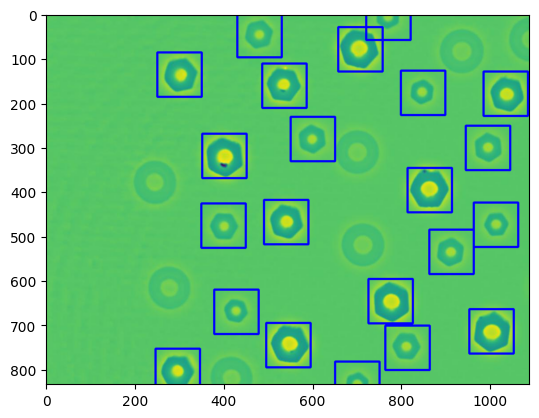

In [7]:
image, gt_boxes = draw_bounding_boxes(path=path, box_size=100)

### Loading pre-trained weight

In [8]:
filepath = '../Model/checkpoints/checkpoint_small_nuts'
trainer1 = Trainer(filepath)
trainer1.model = dt.models.LodeSTAR(input_shape=(None, None, 1))
trainer1.model.load_weights(filepath)

### Testing

In [9]:
reconstruction_path = f'../Data/MATLAB/output/smoothed'
n_images = 8
test_set = [scipy.io.loadmat(f'{reconstruction_path}/reconstruction0{num}.mat')['Spz'] for num in range(1,n_images+1)]
len(test_set)

8

In [10]:
# Detection settings
alpha = 0.1 # 0.1
cutoff = 0.99 # 0.99
mode = "quantile"

2023-03-22 07:57:26.701619: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 29089920 exceeds 10% of free system memory.
2023-03-22 07:57:26.879226: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 29089920 exceeds 10% of free system memory.


1/1 [==============================] - 0s 95ms/step


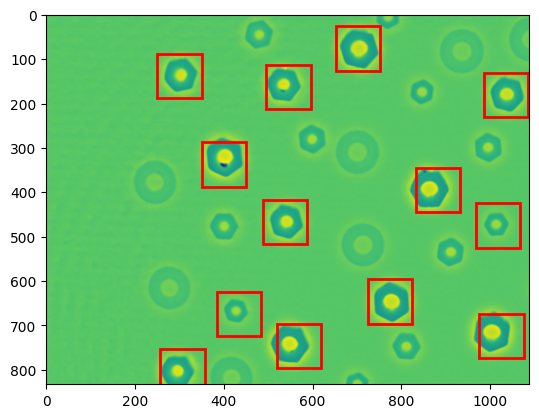

In [11]:
detected_boxes = test(test_set[0], trainer1.model, downsample=2, alpha=alpha, cutoff=cutoff, plotPrevious=False)

### Results comparation

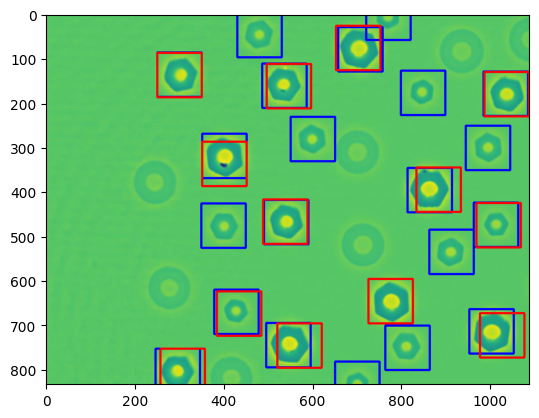

In [12]:
for box in detected_boxes:
    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), thickness=4)

plt.imshow(image)

In [13]:
precision, recall, f1_score, accuracy, conf_matrix, [fp,fn,tp] = generate_metrics(gt_boxes, detected_boxes)

print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

Precision: 1.0
Accuracy: 0.591
Recall: 0.591
F1 Score: 0.743


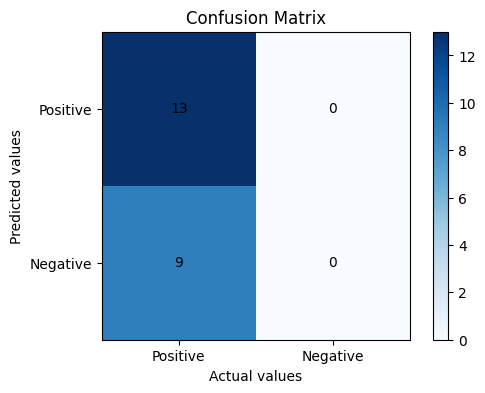

In [14]:
plot_confusion_matrix(conf_matrix)